# Data Visualization Notebook

## Objectives

*   Answer business requirement 1: 
    * The client is interested to have a study to visually differentiate an infected and uninfected leaf.


## Inputs

* inputs/datasets/raw/cherry-leaves/test
* inputs/datasets/raw/cherry-leaves/train
* inputs/datasets/raw/cherry-leaves/validation

## Outputs

* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between parasite-contained and uninfected cell images.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Mildew-Image-Detector/jupyter_notebooks'

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/Mildew-Image-Detector'

Set Inputs

In [6]:
my_data_dir = 'inputs/datasets/raw/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Set Outputs

In [8]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available, create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Set Label Names

In [9]:
# Set the labels
labels = os.listdir(train_path)
print('Label for the images are',labels)

Label for the images are ['healthy', 'powdery_mildew']


---

## Image Visualization

### Image Shape

The first output for this notebook is to save the image shape embeddings.  
In the real-time implementation of AI systems,
these embeddings are highly beneficial. We can use these embeddings directly in the production code
to reshape the data to the desired format without undergoing the long transformation processes.  

We can see from this plot that the average width and height of images are 256 pixels and 256 pixels respectively.  
So, we’ve discovered that the average size of images for the training of the model is (256, 256, 3),
as the width and height are 256 pixels, and an image contains 3 gradients namely red, green,
and blue, which is the standard RGB color range.

We will save this image size embedding into a
pickle file in our output folder for further use.

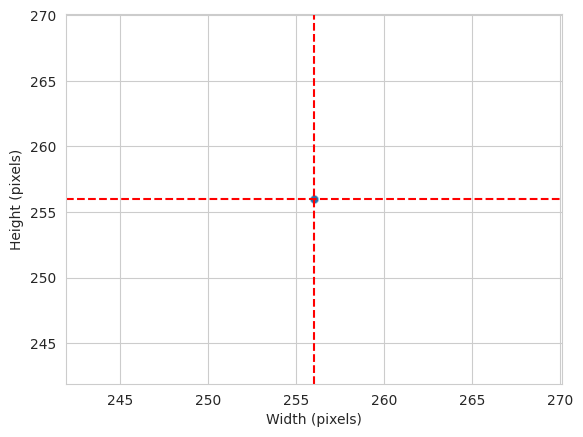

Width average: 256 
Height average: 256


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from matplotlib.image import imread

dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

In [14]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

And lastly we push this information as a pkl file to our outputs folder.

In [15]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Plot and save mean and variability of images per label

This next output will define the mean and standard deviation
of pixel values in parasite-contained cell images and uninfected cell images.

To create such a differentiation plot, we first want to load image data into an array.  Loading
the image data in an array is a very specific task that can be done by using the image function
from the TensorFlow package.

In the load_image_as_array function, we are loading the image shape along with their labels in
an array. The function takes the data path, size of the images, and the number of images per label.  
This function loads the images and their dimension
using the image function.  They are then stored in an X array variable after getting scaled
and reshaped to the new dimensions the number of images, height, width, and color gradient.  
In the y array variable, we store the label names for each image stored in the X array variable.

This function returns the X and Y array variables
to use when plotting the mean and variability of images per label.

In [16]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

2023-01-08 15:58:46.708487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load image shapes and labels in an array
Let’s load image shapes and labels of 30 images of average size,
which we have found in the previous section of the notebook into arrays from the training set
in X and y variables, and print out their shape by running this cell.

In [17]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


### Plot mean and variability of images per label function

Once the load is complete, we will use these variables in the
plot_mean_variability_per_labels function to plot the mean and variability of images per label.
This function is pretty straightforward. It takes X and y as image shape and labels, fig size to
define the figure size of the plot, and save_image flag to save the plot image as arguments.
This function: loops over all labels,
creates subsets of each label, calculates the mean and standard deviation,
creates a figure displaying the mean and variability of images,
and then saves the image in the output folder.

In [18]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")


Run this cell, to plot images and save them in the output directory.

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


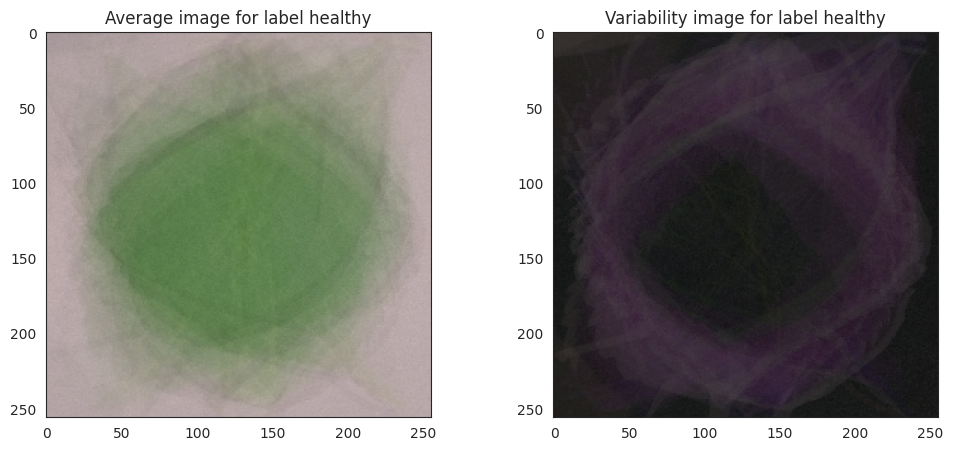

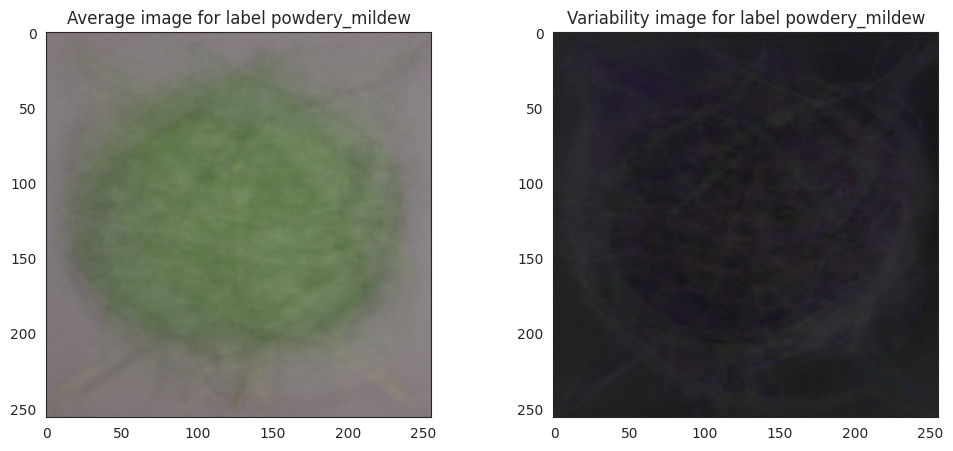

In [19]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

## Difference between healthy and mildewy leaves

Our third output is a figure of plots for average mildew-infected leaf images, average uninfected
leaf images, and the difference between average mildew-infected and uninfected cell images.
The dif_bet_avg_image_labels_data_as_array function does this task for you.
This function takes X, y, figsize, and save_images arguments similar to the previous section
along with two new ones which are label_1 and label_2.
It computes the mean value for the image’s pixels on subsets of both image labels that
are mildew-infected and uninfected. Later it calculates the difference between the
two mean values and plots it using the imshow function from matplotlib and seaborn packages.
We are also saving this figure in the output directory for our dashboard.

In [22]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Run this cell to plot and save the figure. The last output is to develop a pseudo code
to create an image montage for the streamlit dashboard.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


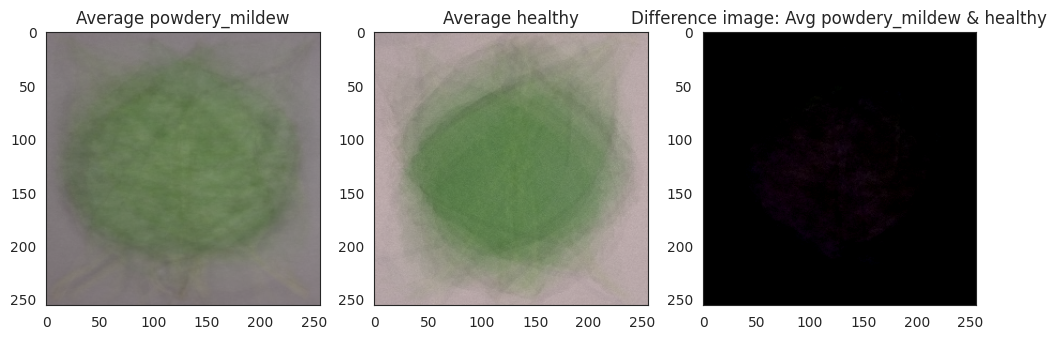

In [23]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='powdery_mildew', label_2='healthy',
                                        figsize=(12,10),
                                        save_image=True
                                        )
